# Earth Observation - Land Classification on EuroSAT dataset
EuroSAT is a large-scale land use and land cover classification dataset derived from multispectral Sentinel-2 satellite imagery covering European continent. EuroSAT is composed of 27,000 georeferenced image patches (64 x 64 pixels) - each patch comprises 13 spectral bands (optical through to shortwave infrared ) resampled to 10m spatila resolution and labelled with one of 10 distinct land cover classes: AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake. Full details including links to journal papers and download instructions may be found here: https://github.com/phelber/eurosat.

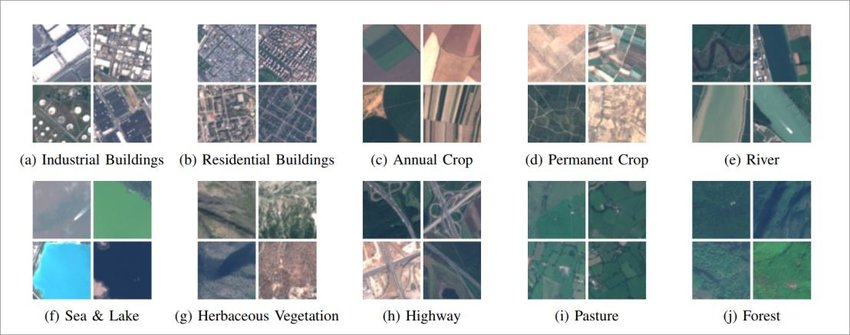

##  1. Setup Notebook Environment

### 1.1 Import all necessary packages

In [ ]:
import os
import ssl
import torch
import random
import numpy as np
import torch.nn as nn
from datetime import datetime
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchvision.datasets import EuroSAT
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard.writer import SummaryWriter

### 1.2 Configure the settings

In [ ]:
config = {'train_test_split':0.1,
          'tr_val_split':0.2,
          'img_size':256,
          'seed':42,
          'lr':1e-4,
          'weight_decay':5e-4,
          'momentum':0.9,
          'gamma':0.2,
          'mini_batch_size':128,
          'epochs':50,
          'milestones':[50,75,90],
         }

### 1.3 Set random seed for Reproducibility guaranteeing:
* control sources of randomness that can cause multiple executions of your application to behave differently.   
* configure PyTorch to avoid using nondeterministic algorithms for some operations, so that multiple calls to those operations, given the same inputs, will produce the same result.

In [ ]:
def set_random_seed(seed=42):
    random.seed(seed) # set python seed
    np.random.seed(seed) # seed the global NumPy random number generator(RNG)
    torch.manual_seed(seed) # seed the RNG for all devices(both CPU and CUDA) 
    torch.use_deterministic_algorithms(True) # avoid nondeterministic algorithms

set_random_seed(seed=config['seed'])

### 1.4 Tracks the active GPU and allocates all new CUDA tensors on that device by default.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

## 2. Data Preparation:

### 2.1 Prepare the dataset: 

In [ ]:
# Transform pipeline
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

# Dataset download
ssl._create_default_https_context = ssl._create_unverified_context # Turn off the ssl verification.
dataset = EuroSAT(root=".", transform=transform, download=True)

# Train/Test split
n = int(len(dataset) * config['train_test_split'])
eurosat_train, eurosat_test = torch.utils.data.random_split(dataset, [n, len(dataset) - n])

### 2.2 Visualize Training Data

In [ ]:
# Print the corresponding label for the image
classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
random_index = random.randrange(len(eurosat_train)) # random select an index
random_image = eurosat_train[random_index][0].numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
random_image = std * random_image + mean
random_image = np.clip(random_image, 0, 1)
print("Image", random_index, "'s label :", eurosat_train[random_index][1], classes[eurosat_train[random_index][1]])
plt.imshow(random_image)

### 2.3 Instantiate PyTorch data loader that feeds the image tensors to our neural network

In [ ]:
# Tr/Val split
n = int(len(eurosat_train) * config['tr_val_split'])
eurosat_tr, eurosat_val = torch.utils.data.random_split(eurosat_train, [n, len(eurosat_train) - n])

# instantiate data loaders
train_dataloader = torch.utils.data.DataLoader(eurosat_tr, batch_size=config['mini_batch_size'], shuffle=True)
val_dataloader = torch.utils.data.DataLoader(eurosat_val, batch_size=config['mini_batch_size'], shuffle=True)
test_dataloader = torch.utils.data.DataLoader(eurosat_test, batch_size=config['mini_batch_size'], shuffle=True)

## 3. Model Training

### 3.1 Creat Resnet-50 model from torchvision

In [ ]:
num_classes = 10
model = models.resnet50()
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding = 3, bias = False)
model.to(device)

### 3.2 Define criterion, optimizer, and scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'], weight_decay=config['weight_decay'])
scheduler = MultiStepLR(optimizer, milestones=config['milestones'], gamma=config['gamma'])

### 3.3 Define the Training Loop
Below, we have a function that performs one training epoch. It enumerates data from the DataLoader, and on each pass of the loop does the following:

* Gets a batch of training data from the DataLoader
* Zeros the optimizer’s gradients
* Performs an inference - that is, gets predictions from the model for an input batch
* Calculates the loss for that set of predictions vs. the labels on the dataset
* Calculates the backward gradients over the learning weights
* Tells the optimizer to perform one learning step - that is, adjust the model’s learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose
* Finally, it reports the averaged epoch loss for comparison with a validation run

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    train_loss = 0.
    train_acc = 0.
    num_correct = 0
    num_samples = 0

    # Here, we use enumerate(train_dataloader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for _, data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        _, predictions = outputs.max(dim=-1)
        num_correct += (predictions == labels).sum()
        num_samples += predictions.size(0)
        
    train_loss = running_loss/len(train_dataloader)
    train_acc = float(num_correct)/float(num_samples)

    return train_loss, train_acc

#### 3.4 Validation
There are a couple of things we’ll want to do once per epoch:

Perform validation by checking our relative loss on a set of data that was not used for training, and report this

Save a copy of the model

Here, we’ll do our reporting in TensorBoard. This will require going to the command line to start TensorBoard, and opening it in another browser tab.

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/eurosat_trainer_{}'.format(timestamp))
epoch_number = 0
tr_acc = 0.0

best_vloss = 1_000_000.

for epoch in range(config['epochs']):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, tr_acc = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    val_acc = 0.0
    num_vcorrect = 0
    num_vsamples = 0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_dataloader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss
            _, vpredictions = voutputs.max(dim=-1)
            num_vcorrect += (vpredictions == vlabels).sum()
            num_vsamples += vpredictions.size(0)

    avg_vloss = running_vloss / len(val_dataloader)
    val_acc = float(num_vcorrect)/float(num_vsamples)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print('ACC train {} valid {}'.format(round(tr_acc*100, 2), round(val_acc*100),2))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.add_scalars('Training vs. Validation Accuracy',
                    { 'Training' : tr_acc, 'Validation' : val_acc },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'runs/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

## 4. Testing

### 4.1 Inference

In [ ]:
model.eval()
running_tloss = 0.
test_acc = 0.
num_tcorrect = 0
num_tsamples = 0
for _, tdata in enumerate(test_dataloader):
    tinputs, tlabels = tdata
    toutputs = model(tinputs)
    tloss = criterion(toutputs, tlabels)
    running_tloss += tloss
    _, tpredictions = toutputs.max(dim=-1)
    num_tcorrect += (tpredictions == tlabels).sum()
    num_tsamples += tpredictions.size(0)

avg_tloss = running_tloss/len(test_dataloader)
test_acc = float(num_tcorrect)/float(num_tsamples)
print('LOSS train {} valid {} test {}'.format(avg_tloss, avg_vloss, avg_tloss))
print('ACC train {} valid {} test {}'.format(round(tr_acc*100, 2), round(val_acc*100),2), round(test_acc*100,2))

### 4.2 Visualize Test Data

In [ ]:
# Print the corresponding label for the image
classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
random_index = random.randrange(len(tinputs)) # random select an index
random_image = tinputs[random_index].numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
random_image = std * random_image + mean
random_image = np.clip(random_image, 0, 1)
print("Image", random_index, "'s label :", tinputs[random_index], tlabels[random_index], "predicted label :", toutputs[random_index])
plt.imshow(random_image)